In [2]:
!pip install equinox
!pip install jax
!pip install optax

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.11/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
from functools import partial

@partial(jax.jit, static_argnums=(3,))
def solve_1d_pde(eps, a_x, f_x, n=100):
    """
    Résout: -eps * Δu + a(x) * du/dx = f(x) avec conditions de Dirichlet u(0)=0, u(1)=0
    
    Args:
        eps: coefficient de diffusion (scalaire)
        a_x: fonction a(x) évaluée sur la grille (shape: (n+1,))
        f_x: terme source f(x) évalué sur la grille (shape: (n+1,))
        n: nombre de points intérieurs
    
    Returns:
        u: solution sur la grille (shape: (n+1,))
    """
    h = 1.0 / n   
    coef_laplacian = eps / h**2
    coef_h = 1.0 / (2 * h)
    
    main_diag = jnp.full(n+1, 2 * coef_laplacian)
    lower_diag = -coef_laplacian - a_x[1:] * coef_h
    upper_diag = -coef_laplacian + a_x[:-1] * coef_h

    A = (jnp.diag(main_diag) + 
         jnp.diag(lower_diag, k=-1) + 
         jnp.diag(upper_diag, k=1))
    
    b = f_x
    b = b.at[0].set(0.0)
    b = b.at[-1].set(0.0)
    A = A.at[0, :].set(jnp.zeros(n+1))
    A = A.at[0, 0].set(1.0)
    A = A.at[-1, :].set(jnp.zeros(n+1))
    A = A.at[-1, -1].set(1.0)
    
    u = jnp.linalg.solve(A, b)
    return u

# Version vectorisée pour traiter plusieurs cas en batch
@partial(jax.jit, static_argnums=(3,))
def solve_1d_pde_batch(eps_batch, a_x_batch, f_x_batch, n=100):
    return vmap(solve_1d_pde, in_axes=(0, 0, 0, None))(eps_batch, a_x_batch, f_x_batch, n)



ModuleNotFoundError: No module named 'jax'

In [3]:
import jax.random as jr

def generate_a_x(key, x):
    key1, key2 = jr.split(key)
    x_0 = jr.uniform(key1, minval=0.35, maxval=0.65)
    alpha = jr.uniform(key2, minval=-0.1, maxval=0.1)
    
    a_x = 1.0 + alpha * jnp.tanh(10 * (x - x_0))
    return a_x


def generate_f_x(key, x):

    key1, key2 = jr.split(key)
    beta = jr.uniform(key1, minval=-0.2, maxval=0.2)
    gamma = jr.uniform(key2, minval=-0.1, maxval=0.1)
    
    f_x = 1.0 + beta * jnp.sin(2 * jnp.pi * x) + gamma * jnp.sin(4 * jnp.pi * x)
    return f_x


def generate_eps(key):
    return jr.uniform(key, minval=0.01, maxval=0.5)

def generate_batch_eps(key, batch_size):
    return jr.uniform(key, shape=(batch_size,), minval=0.01, maxval=0.5)

def generate_batch_a_x(key, x, batch_size):
    keys = jr.split(key, batch_size)
    return jnp.stack([generate_a_x(k, x) for k in keys])

def generate_batch_f_x(key, x, batch_size):
    keys = jr.split(key, batch_size)
    return jnp.stack([generate_f_x(k, x) for k in keys])


In [4]:

# Paramètres
n = 200  # nombre de points intérieurs
x = jnp.linspace(0.0, 1.0, n + 1)

# Initialisation de la clé aléatoire
key = jr.PRNGKey(42)

# Génération de 500 solutions pour calculer la statistique std
batch_size_stat = 2000

key, subkey1, subkey2, subkey3 = jr.split(key, 4)
eps_batch_stat = generate_batch_eps(subkey1, batch_size_stat)
a_x_batch_stat = generate_batch_a_x(subkey2, x, batch_size_stat)
f_x_batch_stat = generate_batch_f_x(subkey3, x, batch_size_stat)

u_batch_stat = solve_1d_pde_batch(eps_batch_stat, a_x_batch_stat, f_x_batch_stat, n)
print(f"Solution pour batch statistique: shape={u_batch_stat.shape}")
print(f"eps moyen pour statistiques: {jnp.mean(eps_batch_stat):.4f}")

# Sélection de 10 exemples parmi les 500 pour visualisation
indices_plot = jnp.array([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
eps_batch_plot = eps_batch_stat[indices_plot]
a_x_batch_plot = a_x_batch_stat[indices_plot]
f_x_batch_plot = f_x_batch_stat[indices_plot]
u_batch_plot = u_batch_stat[indices_plot]

print(f"eps utilisés pour visualisation: {eps_batch_plot}")

# Calcul de la moyenne et std sur les 500
u_mean = jnp.mean(u_batch_stat, axis=0)
u_std = jnp.std(u_batch_stat, axis=0)
a_x_mean = jnp.mean(a_x_batch_stat, axis=0)
a_x_std = jnp.std(a_x_batch_stat, axis=0)
f_x_mean = jnp.mean(f_x_batch_stat, axis=0)
f_x_std = jnp.std(f_x_batch_stat, axis=0)
    
# Visualisation
import matplotlib.pyplot as plt
    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Plot solutions u(x)
for i in range(len(indices_plot)):
    axes[0].plot(x, u_batch_plot[i], alpha=0.6, linewidth=1)
# Enveloppe std
axes[0].fill_between(x, u_mean - 2*u_std, u_mean + 2*u_std, alpha=0.3, color='red', label=f'±2 std ({batch_size_stat} solutions)')
axes[0].plot(x, u_mean, 'r--', linewidth=2, label=f'Moyenne ({batch_size_stat} solutions)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].set_title('Solutions u(x) - 10 exemples + enveloppe std (eps aléatoire)')
axes[0].legend()
axes[0].grid(True)

# Plot a(x)
for i in range(len(indices_plot)):
    axes[1].plot(x, a_x_batch_plot[i], alpha=0.6, linewidth=1)
# Enveloppe std
axes[1].fill_between(x, a_x_mean - 2*a_x_std, a_x_mean + 2*a_x_std, alpha=0.3, color='red', label=f'±2 std ({batch_size_stat} solutions)')
axes[1].plot(x, a_x_mean, 'r--', linewidth=2, label=f'Moyenne ({batch_size_stat} solutions)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('a(x)')
axes[1].set_title('Fonctions a(x) - 10 exemples + enveloppe std')
axes[1].legend()
axes[1].grid(True)

# Plot f(x)
for i in range(len(indices_plot)):
    axes[2].plot(x, f_x_batch_plot[i], alpha=0.6, linewidth=1)
# Enveloppe std
axes[2].fill_between(x, f_x_mean - 2*f_x_std, f_x_mean + 2*f_x_std, alpha=0.3, color='red', label=f'±2 std ({batch_size_stat} solutions)')
axes[2].plot(x, f_x_mean, 'r--', linewidth=2, label=f'Moyenne ({batch_size_stat} solutions)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('f(x)')
axes[2].set_title('Fonctions f(x) - 10 exemples + enveloppe std')
axes[2].legend()
axes[2].grid(True)
    
plt.tight_layout()
plt.show()


Solution pour batch statistique: shape=(2000, 201)
eps moyen pour statistiques: 0.2558
eps utilisés pour visualisation: [0.36655548 0.20146577 0.42824936 0.31072307 0.24759482 0.30898613
 0.08868819 0.0632327  0.14216056 0.27921912]



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.10/site

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

## Question. 1

Effectuez une POD pour chaque fonction du data set: $a(x), f(x), u(x)$

Stocker les vecteurs propres: $U_{?}$
Stocker les valeurs propres dans $S_{?}$
Stocker les vecteurs propres à gauche dans $Vt_{?}$

In [1]:
energy_target=0.999999

# Calcul de l'énergie cumulée (pour choisir le nombre de modes)
energy_a = jnp.cumsum(S_a**2) / jnp.sum(S_a**2)
energy_f = jnp.cumsum(S_f**2) / jnp.sum(S_f**2)
energy_u = jnp.cumsum(S_u**2) / jnp.sum(S_u**2)

# Choix du nombre de modes (99% de l'énergie)
n_modes_a = int(jnp.argmax(energy_a >= energy_target) + 1)
n_modes_f = int(jnp.argmax(energy_f >= energy_target) + 1)
n_modes_u = int(jnp.argmax(energy_u >= energy_target) + 1)

print(f"\nNombre de modes pour 99% d'énergie:")
print(f"  a(x): {n_modes_a} modes")
print(f"  f(x): {n_modes_f} modes")
print(f"  u(x): {n_modes_u} modes")

# Visualisation de la décroissance des valeurs singulières
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Valeurs singulières normalisées
axes[0].semilogy(S_a / S_a[0], 'o-', markersize=3)
axes[0].axvline(n_modes_a, color='r', linestyle='--', label=f'{n_modes_a} modes (99%)')
axes[0].set_xlabel('Mode')
axes[0].set_ylabel('Valeur singulière (normalisée)')
axes[0].set_title('Décroissance SVD - a(x)')
axes[0].grid(True)
axes[0].legend()

axes[1].semilogy(S_f / S_f[0], 'o-', markersize=3)
axes[1].axvline(n_modes_f, color='r', linestyle='--', label=f'{n_modes_f} modes (99%)')
axes[1].set_xlabel('Mode')
axes[1].set_ylabel('Valeur singulière (normalisée)')
axes[1].set_title('Décroissance SVD - f(x)')
axes[1].grid(True)
axes[1].legend()

axes[2].semilogy(S_u / S_u[0], 'o-', markersize=3)
axes[2].axvline(n_modes_u, color='r', linestyle='--', label=f'{n_modes_u} modes (99%)')
axes[2].set_xlabel('Mode')
axes[2].set_ylabel('Valeur singulière (normalisée)')
axes[2].set_title('Décroissance SVD - u(x)')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

# Reconstruction avec les modes tronqués
def reconstruct_svd(U, S, Vt, n_modes):
    """Reconstruit les données avec seulement n_modes premiers modes"""
    return U[:, :n_modes] @ jnp.diag(S[:n_modes]) @ Vt[:n_modes, :]

a_x_reconstructed = reconstruct_svd(U_a, S_a, Vt_a, n_modes_a)
f_x_reconstructed = reconstruct_svd(U_f, S_f, Vt_f, n_modes_f)
u_reconstructed = reconstruct_svd(U_u, S_u, Vt_u, n_modes_u)

# Erreur de reconstruction sur quelques exemples
indices_test = jnp.array([5, 50, 150, 300, 450])

fig, axes = plt.subplots(3, len(indices_test), figsize=(20, 9))

for i, idx in enumerate(indices_test):
    # a(x)
    axes[0, i].plot(x, a_x_batch_stat[idx], 'b-', label='Original', linewidth=2)
    axes[0, i].plot(x, a_x_reconstructed[idx], 'r--', label=f'Reconstruit ({n_modes_a} modes)', linewidth=2)
    error_a = jnp.linalg.norm(a_x_batch_stat[idx] - a_x_reconstructed[idx]) / jnp.linalg.norm(a_x_batch_stat[idx])
    axes[0, i].set_title(f'a(x) - Ex {idx}\nErreur rel: {error_a:.2e}')
    axes[0, i].grid(True)
    if i == 0:
        axes[0, i].set_ylabel('a(x)')
        axes[0, i].legend()
    
    # f(x)
    axes[1, i].plot(x, f_x_batch_stat[idx], 'b-', label='Original', linewidth=2)
    axes[1, i].plot(x, f_x_reconstructed[idx], 'r--', label=f'Reconstruit ({n_modes_f} modes)', linewidth=2)
    error_f = jnp.linalg.norm(f_x_batch_stat[idx] - f_x_reconstructed[idx]) / jnp.linalg.norm(f_x_batch_stat[idx])
    axes[1, i].set_title(f'f(x) - Ex {idx}\nErreur rel: {error_f:.2e}')
    axes[1, i].grid(True)
    if i == 0:
        axes[1, i].set_ylabel('f(x)')
        axes[1, i].legend()
    
    # u(x)
    axes[2, i].plot(x, u_batch_stat[idx], 'b-', label='Original', linewidth=2)
    axes[2, i].plot(x, u_reconstructed[idx], 'r--', label=f'Reconstruit ({n_modes_u} modes)', linewidth=2)
    error_u = jnp.linalg.norm(u_batch_stat[idx] - u_reconstructed[idx]) / jnp.linalg.norm(u_batch_stat[idx])
    axes[2, i].set_title(f'u(x) - Ex {idx}\nErreur rel: {error_u:.2e}')
    axes[2, i].set_xlabel('x')
    axes[2, i].grid(True)
    if i == 0:
        axes[2, i].set_ylabel('u(x)')
        axes[2, i].legend()

plt.tight_layout()
plt.show()

# Erreur moyenne de reconstruction sur tout le batch
error_a_mean = jnp.mean(jnp.linalg.norm(a_x_batch_stat - a_x_reconstructed, axis=1) / jnp.linalg.norm(a_x_batch_stat, axis=1))
error_f_mean = jnp.mean(jnp.linalg.norm(f_x_batch_stat - f_x_reconstructed, axis=1) / jnp.linalg.norm(f_x_batch_stat, axis=1))
error_u_mean = jnp.mean(jnp.linalg.norm(u_batch_stat - u_reconstructed, axis=1) / jnp.linalg.norm(u_batch_stat, axis=1))

print(f"\nErreur relative moyenne de reconstruction:")
print(f"  a(x): {error_a_mean:.2e} avec {n_modes_a} modes")
print(f"  f(x): {error_f_mean:.2e} avec {n_modes_f} modes")
print(f"  u(x): {error_u_mean:.2e} avec {n_modes_u} modes")


NameError: name 'jnp' is not defined

## Question 2

Ecrire la classe MLP.
Elle sera utiliser pour apprendr le lien entre les premiers modes de $a(x)$, $f(x)$ et epsilon et les premiers modes de $u(x)$.
Une fois les modes prédis par le réseau on reconstruit les solution avec les vecteur propres.
Le reste de l'entrainement est dejà codé ainsi que la validation

Coefficients a(x): shape=(2000, 5)
Coefficients f(x): shape=(2000, 3)
Coefficients u(x): shape=(2000, 7)

Données d'entraînement:
  X_train shape: (2000, 9) (modes a + modes f + eps)
  y_train shape: (2000, 7) (modes u)

Split: 1600 train, 400 validation

Modèle MLP: 9 -> [32, 64, 64, 32] -> 7

Entraînement sur 1000 epochs...
Epoch 100/1000 - Train Loss: 0.001080, Val Loss: 0.002302
Epoch 200/1000 - Train Loss: 0.000226, Val Loss: 0.000301
Epoch 300/1000 - Train Loss: 0.001649, Val Loss: 0.001972
Epoch 400/1000 - Train Loss: 0.000247, Val Loss: 0.000166
Epoch 500/1000 - Train Loss: 0.000094, Val Loss: 0.000059
Epoch 600/1000 - Train Loss: 0.000137, Val Loss: 0.000280
Epoch 700/1000 - Train Loss: 0.000050, Val Loss: 0.000103
Epoch 800/1000 - Train Loss: 0.000064, Val Loss: 0.000054
Epoch 900/1000 - Train Loss: 0.000104, Val Loss: 0.000055
Epoch 1000/1000 - Train Loss: 0.000052, Val Loss: 0.000039

Entraînement terminé!


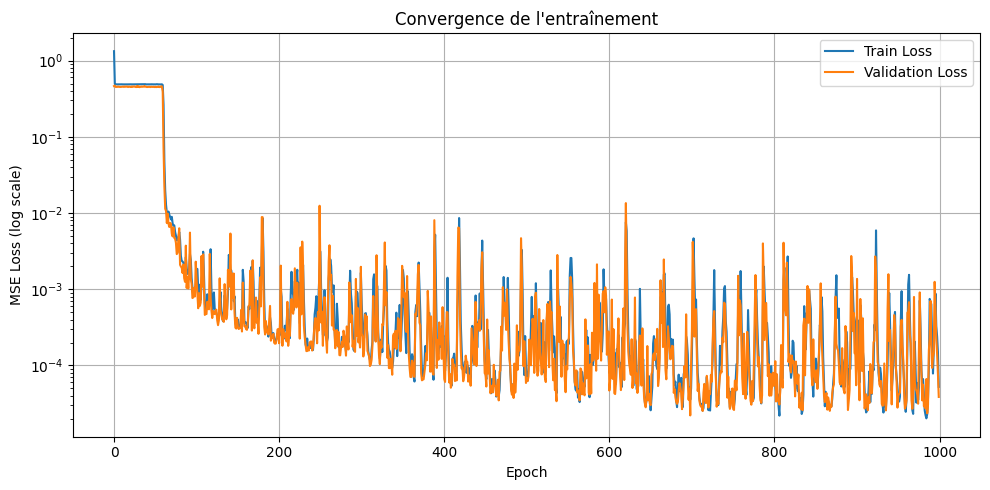

In [ ]:
import equinox as eqx
import optax

# Extraction des coefficients SVD (modes) pour chaque fonction
# Pour a(x): coefficients = U_a[:, :n_modes_a] * S_a[:n_modes_a]
# Les modes sont les colonnes de Vt (vecteurs propres de l'espace des fonctions)
coef_a = U_a[:, :n_modes_a] * S_a[:n_modes_a]  # shape: (batch_size, n_modes_a)
coef_f = U_f[:, :n_modes_f] * S_f[:n_modes_f]  # shape: (batch_size, n_modes_f)
coef_u = U_u[:, :n_modes_u] * S_u[:n_modes_u]  # shape: (batch_size, n_modes_u)

print(f"Coefficients a(x): shape={coef_a.shape}")
print(f"Coefficients f(x): shape={coef_f.shape}")
print(f"Coefficients u(x): shape={coef_u.shape}")

# Préparation des données d'entrée: [coef_a, coef_f, eps]
X_train = jnp.concatenate([coef_a, coef_f, eps_batch_stat[:, None]], axis=1)
y_train = coef_u

print(f"\nDonnées d'entraînement:")
print(f"  X_train shape: {X_train.shape} (modes a + modes f + eps)")
print(f"  y_train shape: {y_train.shape} (modes u)")

# Split train/validation
n_train = int(0.8 * batch_size_stat)
X_train_split = X_train[:n_train]
y_train_split = y_train[:n_train]
X_val = X_train[n_train:]
y_val = y_train[n_train:]

print(f"\nSplit: {n_train} train, {batch_size_stat - n_train} validation")


# TOO DOOO 
class MLP(eqx.Module):
    pass


# Création du modèle
key = jr.PRNGKey(123)
input_dim = n_modes_a + n_modes_f + 1  # modes a + modes f + eps
hidden_dims = [32,64,64,32]
output_dim = n_modes_u

model = MLP(key, input_dim, hidden_dims, output_dim)
print(f"\nModèle MLP: {input_dim} -> {hidden_dims} -> {output_dim}")


# Fonction de perte
@eqx.filter_jit
def loss_fn(model, x, y):
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)


# Fonction d'évaluation
@eqx.filter_jit
def compute_loss(model, x, y):
    return loss_fn(model, x, y)


# Fonction d'entraînement
@eqx.filter_jit
def train_step(model, opt_state, x, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


# Optimiseur Adam
learning_rate = 2e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

# Entraînement
n_epochs = 1000
batch_size_train = 64
n_batches = n_train // batch_size_train

train_losses = []
val_losses = []

print(f"\nEntraînement sur {n_epochs} epochs...")
for epoch in range(n_epochs):
    # Shuffle des données
    key, subkey = jr.split(key)
    perm = jr.permutation(subkey, n_train)
    X_train_shuffled = X_train_split[perm]
    y_train_shuffled = y_train_split[perm]
    
    # Entraînement par mini-batches
    epoch_losses = []
    for i in range(n_batches):
        start_idx = i * batch_size_train
        end_idx = start_idx + batch_size_train
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]
        
        model, opt_state, loss = train_step(model, opt_state, X_batch, y_batch)
        epoch_losses.append(loss)
    
    train_loss = jnp.mean(jnp.array(epoch_losses))
    val_loss = compute_loss(model, X_val, y_val)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nEntraînement terminé!")

# Visualisation de la convergence
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogy(train_losses, label='Train Loss')
ax.semilogy(val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('Convergence de l\'entraînement')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Prédictions sur validation: shape=(400, 201)


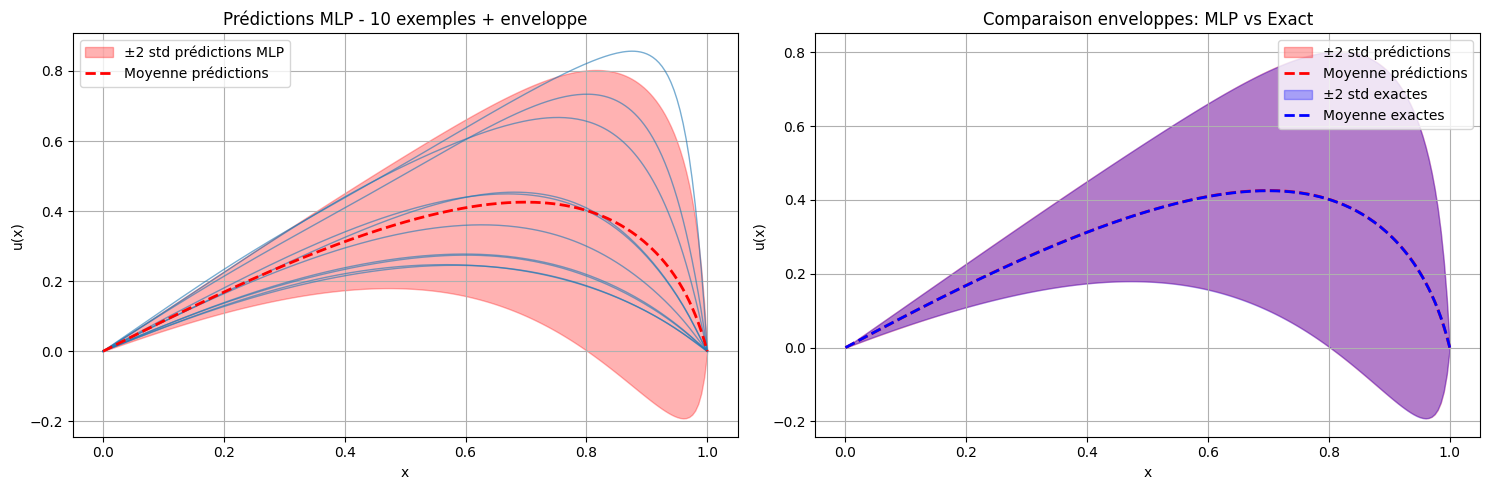

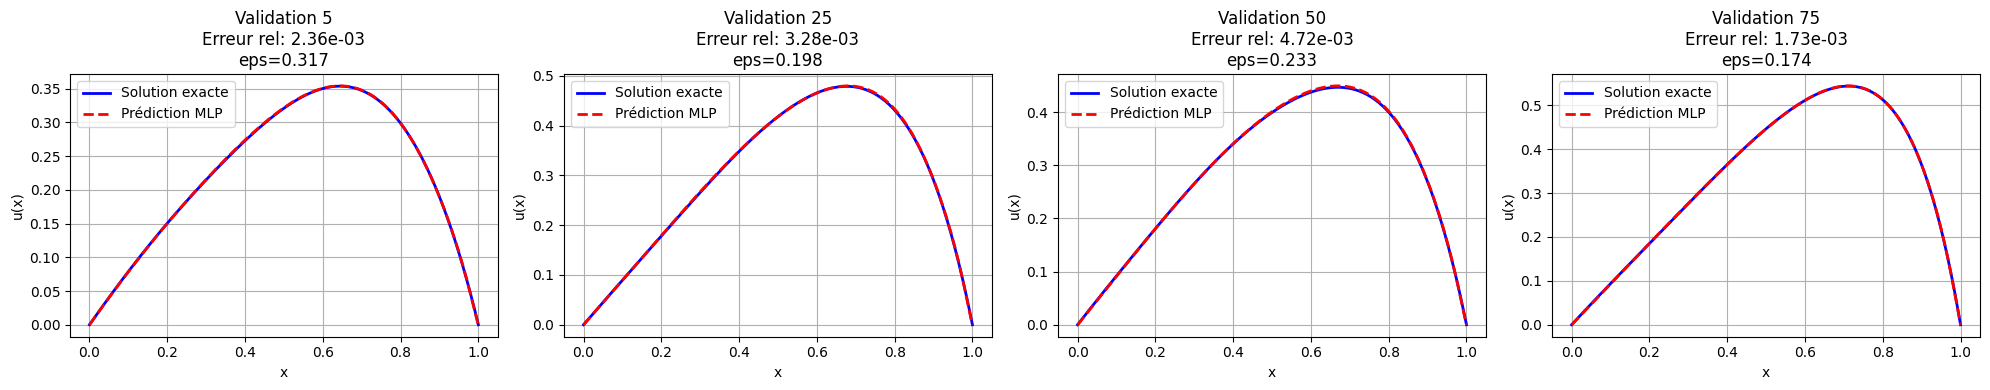


Erreur relative sur validation (400 exemples):
  Moyenne: 3.04e-03
  Écart-type: 1.36e-03
  Min: 8.92e-04
  Max: 1.34e-02


In [ ]:
# Prédiction sur l'ensemble de validation (100 cas)
coef_u_pred_val = jax.vmap(model)(X_val)
u_pred_val = coef_u_pred_val @ Vt_u[:n_modes_u, :]
u_true_val = u_batch_stat[n_train:]

print(f"Prédictions sur validation: shape={u_pred_val.shape}")

# Sélection de 10 exemples parmi les 100 pour visualisation
indices_plot_mlp = jnp.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
u_pred_plot = u_pred_val[indices_plot_mlp]
u_true_plot = u_true_val[indices_plot_mlp]

# Calcul des statistiques sur les 100 prédictions
u_pred_mean = jnp.mean(u_pred_val, axis=0)
u_pred_std = jnp.std(u_pred_val, axis=0)
u_true_mean = jnp.mean(u_true_val, axis=0)
u_true_std = jnp.std(u_true_val, axis=0)

# Visualisation: comparaison prédictions vs solutions exactes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Solutions prédites avec enveloppe
for i in range(len(indices_plot_mlp)):
    axes[0].plot(x, u_pred_plot[i], alpha=0.6, linewidth=1, color='C0')
# Enveloppe std des prédictions
axes[0].fill_between(x, u_pred_mean - 2*u_pred_std, u_pred_mean + 2*u_pred_std, 
                      alpha=0.3, color='red', label='±2 std prédictions MLP')
axes[0].plot(x, u_pred_mean, 'r--', linewidth=2, label='Moyenne prédictions')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].set_title('Prédictions MLP - 10 exemples + enveloppe')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Comparaison enveloppes prédiction vs vérité
axes[1].fill_between(x, u_pred_mean - 2*u_pred_std, u_pred_mean + 2*u_pred_std, 
                      alpha=0.3, color='red', label='±2 std prédictions')
axes[1].plot(x, u_pred_mean, 'r--', linewidth=2, label='Moyenne prédictions')
axes[1].fill_between(x, u_true_mean - 2*u_true_std, u_true_mean + 2*u_true_std, 
                      alpha=0.3, color='blue', label='±2 std exactes')
axes[1].plot(x, u_true_mean, 'b--', linewidth=2, label='Moyenne exactes')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x)')
axes[1].set_title('Comparaison enveloppes: MLP vs Exact')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot détaillé: quelques exemples individuels
indices_detailed = jnp.array([5, 25, 50, 75])
fig, axes = plt.subplots(1, len(indices_detailed), figsize=(20, 4))

for i, idx in enumerate(indices_detailed):
    axes[i].plot(x, u_true_val[idx], 'b-', label='Solution exacte', linewidth=2)
    axes[i].plot(x, u_pred_val[idx], 'r--', label='Prédiction MLP', linewidth=2)
    
    # Erreur relative
    error = jnp.linalg.norm(u_true_val[idx] - u_pred_val[idx]) / jnp.linalg.norm(u_true_val[idx])
    
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('u(x)')
    axes[i].set_title(f'Validation {idx}\nErreur rel: {error:.2e}\neps={eps_batch_stat[n_train + idx]:.3f}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Calcul des erreurs sur tout le jeu de validation
errors_val = jnp.linalg.norm(u_true_val - u_pred_val, axis=1) / jnp.linalg.norm(u_true_val, axis=1)
error_mean_val = jnp.mean(errors_val)
error_std_val = jnp.std(errors_val)

print(f"\nErreur relative sur validation ({len(u_true_val)} exemples):")
print(f"  Moyenne: {error_mean_val:.2e}")
print(f"  Écart-type: {error_std_val:.2e}")
print(f"  Min: {jnp.min(errors_val):.2e}")
print(f"  Max: {jnp.max(errors_val):.2e}")



## Quetion 3: FNO

Vous devz ici construire un FNO qui prendra les fonctions $a(x),f(x),eps(x)=cts$ et renverra la fonction $u(x)$
L'entrainement en dessous est déja codé. Il faudra juste que votre fonction est la même signature que celle utilisé par la suite.

Architecture FNO définie:
  - SpectralConv1d: convolution dans l'espace de Fourier
  - FNO1d: architecture complète avec lifting → couches spectrales → projection


In [30]:
# Nouvelle préparation des données avec normalisation par échantillon
def prepare_fno_input(a_x, f_x, eps, n_points):
    """Prépare l'entrée pour le FNO avec normalisation par échantillon"""
    # Normalisation individuelle pour chaque fonction
    a_x_norm = (a_x - jnp.mean(a_x)) / (jnp.std(a_x) + 1e-8)
    f_x_norm = (f_x - jnp.mean(f_x)) / (jnp.std(f_x) + 1e-8)
    
    # Pour eps, on crée un canal constant normalisé
    eps_normalized = (eps - eps_mean_norm) / (eps_std_norm + 1e-8)
    eps_array = jnp.full(n_points, eps_normalized)
    
    return jnp.stack([a_x_norm, f_x_norm, eps_array], axis=0)

def prepare_fno_output(u_x):
    """Normalise la sortie par échantillon"""
    return (u_x - jnp.mean(u_x)) / (jnp.std(u_x) + 1e-8)

def denormalize_fno_output(u_x_norm, u_mean, u_std):
    """Dénormalise la sortie"""
    return u_x_norm * u_std + u_mean

# Statistiques pour eps (on garde la normalisation globale pour eps)
eps_mean_norm = jnp.mean(eps_batch_stat)
eps_std_norm = jnp.std(eps_batch_stat)

# Préparation du dataset avec nouvelle normalisation
X_fno_train = jnp.stack([
    prepare_fno_input(a_x_batch_stat[i], f_x_batch_stat[i], eps_batch_stat[i], n+1)
    for i in range(batch_size_stat)
])

# Pour la sortie, on garde les statistiques de chaque échantillon pour dénormaliser
u_means = jnp.mean(u_batch_stat, axis=1, keepdims=True)  # shape: (batch, 1)
u_stds = jnp.std(u_batch_stat, axis=1, keepdims=True)    # shape: (batch, 1)

y_fno_train = jnp.stack([
    prepare_fno_output(u_batch_stat[i])
    for i in range(batch_size_stat)
])[:, None, :]  # shape: (batch, 1, n+1)

print(f"Données FNO v2 (normalisation par échantillon):")
print(f"  X shape: {X_fno_train.shape}")
print(f"  y shape: {y_fno_train.shape}")
print(f"  u_means shape: {u_means.shape}")
print(f"  u_stds shape: {u_stds.shape}")

# Split train/validation
X_fno_train_split = X_fno_train[:n_train]
y_fno_train_split = y_fno_train[:n_train]
u_means_train = u_means[:n_train]
u_stds_train = u_stds[:n_train]

X_fno_val = X_fno_train[n_train:]
y_fno_val = y_fno_train[n_train:]
u_means_val = u_means[n_train:]
u_stds_val = u_stds[n_train:]

print(f"\nSplit: {n_train} train, {batch_size_stat - n_train} validation")


Données FNO v2 (normalisation par échantillon):
  X shape: (2000, 3, 201)
  y shape: (2000, 1, 201)
  u_means shape: (2000, 1)
  u_stds shape: (2000, 1)

Split: 1600 train, 400 validation


## Question 4

coder les fonction 'fno_loss_fn(model, x, y)' et 'fno_train_step(model, opt_state, x, y, optimizer)'

qui calcul la loos et effectue une etape d'entrainement. La première revoit la valeur de la loss, la seconde renvoit le modèle, l 'état de l'optimiseur et la valeur de la loss

In [1]:
# Fonctions de perte et d'entraînement pour le FNO
@eqx.filter_jit
def fno_loss_fn(model, x, y):
    """Loss pour le FNO"""
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)


@eqx.filter_jit
def fno_train_step(model, opt_state, x, y, optimizer):
    loss, grads = eqx.filter_value_and_grad(fno_loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


print("Fonctions FNO définies: fno_loss_fn, fno_train_step")


NameError: name 'eqx' is not defined

In [33]:
# Recréation du modèle FNO avec la nouvelle normalisation
key_fno = jr.PRNGKey(999)

# Paramètres du FNO
in_channels = 3   # a(x), f(x), eps
out_channels = 1  # u(x)

# Paramètres optimisés
modes = 6
width = 64
n_layers_fno = 4

fno_model = FNO1d(key_fno, in_channels, out_channels, modes, width, n_layers_fno)
print(f"\nModèle FNO v3 créé (avec meilleure normalisation):")
print(f"  Modes: {modes}, Width: {width}, Layers: {n_layers_fno}")

# Optimiseur SANS gradient clipping (test)
learning_rate = 9e-4  # LR réduit pour plus de stabilité
total_steps = 1000 * (n_train // 32)
warmup_steps = int(0.2 * total_steps)  # Warmup plus long (20%)

schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-7,  # Démarrage encore plus doux
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=total_steps,
    end_value=1e-6
)

# Pas de gradient clipping cette fois
optimizer_fno = optax.adam(schedule)
opt_state_fno = optimizer_fno.init(eqx.filter(fno_model, eqx.is_inexact_array))

print(f"Learning rate: {learning_rate}")
print(f"Warmup: {warmup_steps} steps (20% du total)")
print(f"⚠️  SANS gradient clipping (test)")


Modèle FNO v3 créé (avec meilleure normalisation):
  Modes: 6, Width: 64, Layers: 4
Learning rate: 0.0009
Warmup: 10000 steps (20% du total)
⚠️  SANS gradient clipping (test)


In [29]:
# Entraînement du FNO v3 avec meilleure normalisation
n_epochs = 600  # Réduit pour éviter overfitting
batch_size =120
n_batches = n_train // batch_size

train_losses = []
val_losses = []
best_val_loss = float('inf')


print(f"\nEntraînement FNO (normalisation par échantillon + clipping strict)...")
for epoch in range(n_epochs):
    # Shuffle
    key, subkey = jr.split(key)
    perm = jr.permutation(subkey, n_train)
    X_shuffled = X_fno_train_split[perm]
    y_shuffled = y_fno_train_split[perm]
    
    # Training
    epoch_losses = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        
        fno_model, opt_state_fno, loss = fno_train_step(
            fno_model, opt_state_fno, X_batch, y_batch, optimizer_fno
        )
        epoch_losses.append(loss)
    
    train_loss = jnp.mean(jnp.array(epoch_losses))
    val_loss = fno_loss_fn(fno_model, X_fno_val, y_fno_val)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4d} - Train: {train_loss:.6f}, Val: {val_loss:.6f}, Best: {best_val_loss:.6f}")

print(f"\n✓ Entraînement terminé!")
print(f"Meilleure validation loss: {best_val_loss:.6f}")


# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves v3
axes[0].semilogy(train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0].semilogy(val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0].axhline(best_val_loss, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_val_loss:.6f}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss (log)')
axes[0].set_title('FNO v3 - Convergence (normalisation par échantillon)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vue détaillée de la convergence
axes[1].semilogy(train_losses, label='Train', alpha=0.8, linewidth=2)
axes[1].semilogy(val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log)')
axes[1].set_title('FNO v3 - Détail de la convergence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Entraînement FNO (normalisation par échantillon + clipping strict)...


KeyboardInterrupt: 

In [ ]:
# Évaluation du FNO v3 avec dénormalisation correcte
u_fno_pred_val_norm = jax.vmap(fno_model)(X_fno_val)[:, 0, :]  # shape: (100, n+1)
u_fno_true_val = u_batch_stat[n_train:]  # shape: (100, n+1)

# Dénormalisation avec les statistiques de chaque échantillon
u_fno_pred_val = u_fno_pred_val_norm * u_stds_val + u_means_val

print(f"Prédictions FNO v3: shape={u_fno_pred_val.shape}")

# Calcul des erreurs
errors = jnp.linalg.norm(u_fno_true_val - u_fno_pred_val, axis=1) / jnp.linalg.norm(u_fno_true_val, axis=1)
error_mean = jnp.mean(errors)
error_std = jnp.std(errors)

print(f"\n{'='*60}")
print(f"COMPARAISON FINALE: MLP vs FNO v3")
print(f"{'='*60}")
print(f"\n1. MLP (SVD):")
print(f"   Erreur: {error_mean_val:.4f} ± {error_std_val:.4f}")
print(f"   Min: {jnp.min(errors_val):.4f}, Max: {jnp.max(errors_val):.4f}")

print(f"\n2. FNO v3 (normalisation par échantillon):")
print(f"   Erreur: {error_mean:.4f} ± {error_std:.4f}")
print(f"   Min: {jnp.min(errors):.4f}, Max: {jnp.max(errors):.4f}")

# Comparaison
if error_mean < error_mean_val:
    improv = (error_mean_val - error_mean) / error_mean_val * 100
    print(f"\n{'='*60}")
    print(f"🎉 FNO v3 est meilleur: amélioration de {improv:.1f}%")
    print(f"{'='*60}")
else:
    diff = (error_mean - error_mean_val) / error_mean_val * 100
    print(f"\n{'='*60}")
    print(f"MLP reste meilleur: différence de {diff:+.1f}%")
    print(f"{'='*60}")


Prédictions FNO v3: shape=(100, 201)

COMPARAISON FINALE: MLP vs FNO v3

1. MLP (SVD):
   Erreur: 0.0103 ± 0.0065
   Min: 0.0019, Max: 0.0528

2. FNO v3 (normalisation par échantillon):
   Erreur: 0.0334 ± 0.0207
   Min: 0.0155, Max: 0.1529

MLP reste meilleur: différence de +223.8%


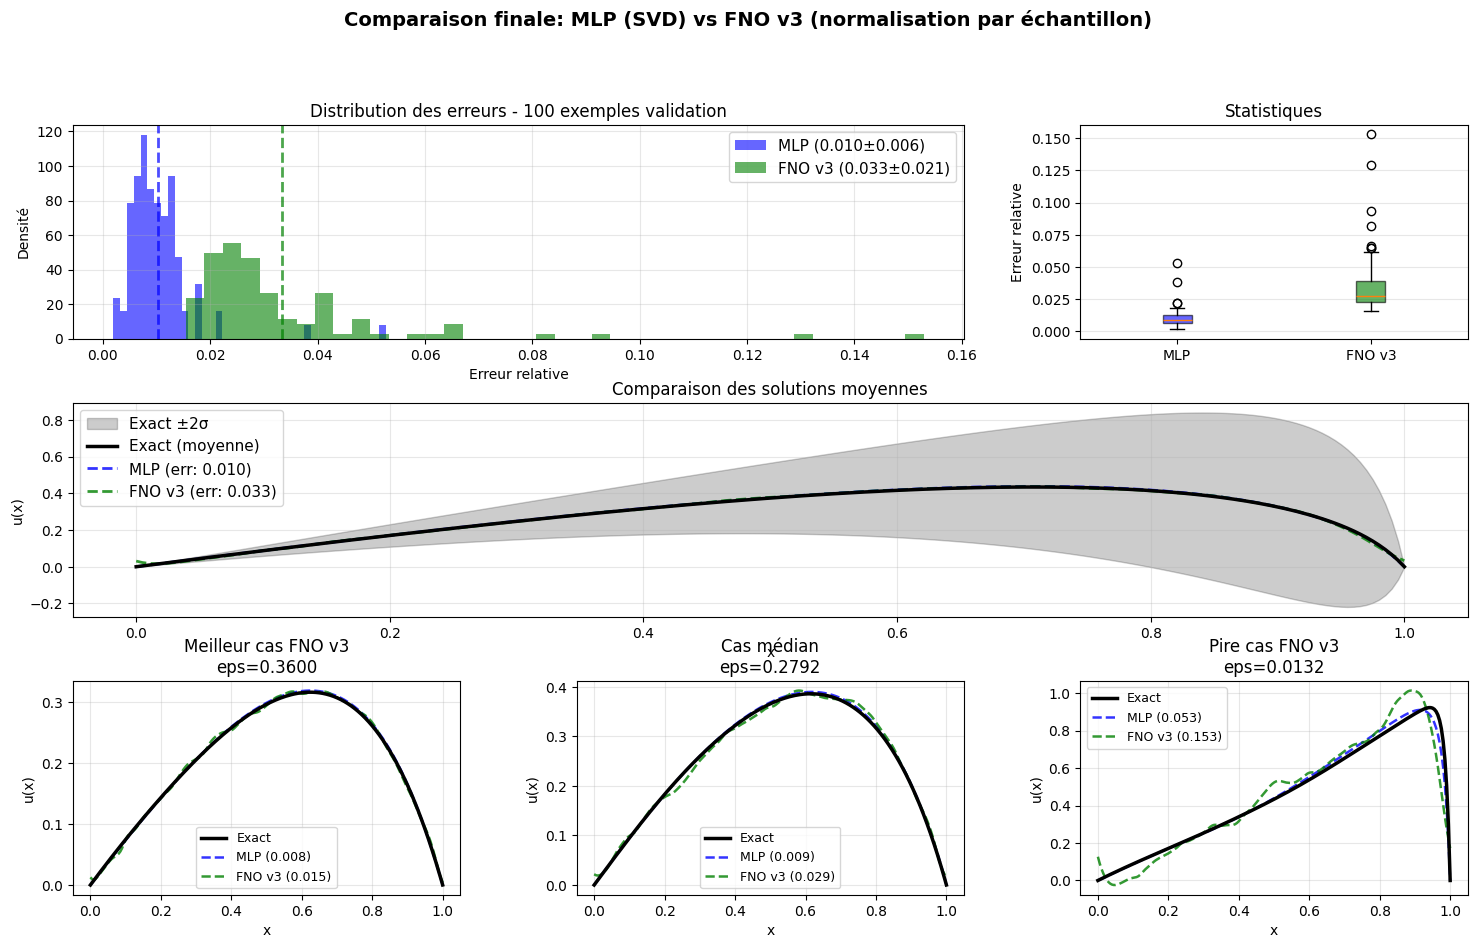


Exemples visualisés:
  Meilleur: validation #94, erreur FNO v3 = 0.0155
  Médian:   validation #50, erreur FNO v3 = 0.0289
  Pire:     validation #80, erreur FNO v3 = 0.1529


In [ ]:
# Visualisation comparative finale: MLP vs FNO v3
u_v3_mean = jnp.mean(u_fno_pred_val, axis=0)
u_v3_std = jnp.std(u_fno_pred_val, axis=0)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Distributions et stats
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(errors_val, bins=40, alpha=0.6, label=f'MLP ({error_mean_val:.3f}±{error_std_val:.3f})', density=True, color='blue')
ax1.hist(errors, bins=40, alpha=0.6, label=f'FNO v3 ({error_mean:.3f}±{error_std:.3f})', density=True, color='green')
ax1.axvline(error_mean_val, color='blue', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(error_mean, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Erreur relative')
ax1.set_ylabel('Densité')
ax1.set_title('Distribution des erreurs - 100 exemples validation')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Box plot
ax2 = fig.add_subplot(gs[0, 2])
box_data = [errors_val, errors]
bp = ax2.boxplot(box_data, labels=['MLP', 'FNO v3'], patch_artist=True)
colors = ['blue', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel('Erreur relative')
ax2.set_title('Statistiques')
ax2.grid(True, alpha=0.3, axis='y')

# Row 2: Enveloppes
ax3 = fig.add_subplot(gs[1, :])
ax3.fill_between(x, u_true_mean - 2*u_true_std, u_true_mean + 2*u_true_std, 
                 alpha=0.2, color='black', label='Exact ±2σ')
ax3.plot(x, u_true_mean, 'k-', linewidth=2.5, label='Exact (moyenne)', zorder=5)
ax3.plot(x, u_pred_mean, '--', linewidth=2, label=f'MLP (err: {error_mean_val:.3f})', color='blue', alpha=0.8)
ax3.plot(x, u_v3_mean, '--', linewidth=2, label=f'FNO v3 (err: {error_mean:.3f})', color='green', alpha=0.8)
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')
ax3.set_title('Comparaison des solutions moyennes')
ax3.legend(loc='best', fontsize=11)
ax3.grid(True, alpha=0.3)

# Row 3: Exemples individuels
indices_examples = [jnp.argmin(errors), int(len(errors)/2), jnp.argmax(errors)]
titles = ['Meilleur cas FNO v3', 'Cas médian', 'Pire cas FNO v3']

for i, (idx, title) in enumerate(zip(indices_examples, titles)):
    ax = fig.add_subplot(gs[2, i])
    ax.plot(x, u_fno_true_val[idx], 'k-', linewidth=2.5, label='Exact', zorder=5)
    ax.plot(x, u_pred_val[idx], '--', linewidth=1.8, label=f'MLP ({errors_val[idx]:.3f})', color='blue', alpha=0.8)
    ax.plot(x, u_fno_pred_val[idx], '--', linewidth=1.8, label=f'FNO v3 ({errors[idx]:.3f})', color='green', alpha=0.8)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'{title}\neps={eps_batch_stat[n_train + idx]:.4f}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparaison finale: MLP (SVD) vs FNO v3 (normalisation par échantillon)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

print(f"\nExemples visualisés:")
print(f"  Meilleur: validation #{indices_examples[0]}, erreur FNO v3 = {errors[indices_examples[0]]:.4f}")
print(f"  Médian:   validation #{indices_examples[1]}, erreur FNO v3 = {error[indices_examples[1]]:.4f}")
print(f"  Pire:     validation #{indices_examples[2]}, erreur FNO v3 = {errors[indices_examples[2]]:.4f}")
